In [1]:
import os, glob
import base64
import graphviz
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter
from rdkit import Chem
from rdkit.Chem import Draw

# Display the updated DataFrame in the notebook
from IPython.display import display

random_seed = 42
data_folder = 'data'

### Load the data

In [2]:
# load the dataframe from pickle files
select_properties_df = pd.read_pickle(os.path.join(data_folder, 'Select_properties.pkl'))
yields_df = pd.read_pickle(os.path.join(data_folder, 'Yields.pkl'))
yield_data_df = pd.read_pickle(os.path.join(data_folder, 'yield_data_df.pkl'))
select_properties_data_df = pd.read_pickle(os.path.join(data_folder, 'select_properties_data_df.pkl'))
select_properties_data_removed_highlycorr_df = pd.read_pickle(os.path.join(data_folder, 'select_properties_data_removed_highlycorr_df.pkl'))

### Normalize the data

In [3]:
# perform normalization on the properties dataframe
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, RobustScaler

scaler = StandardScaler()
# scaler = PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
# scaler = QuantileTransformer(n_quantiles=4, output_distribution='normal', ignore_implicit_zeros=False, subsample=100000, random_state=None, copy=True)
# scaler = RobustScaler(quantile_range=(25.0, 75.0), copy=True, with_centering=True, with_scaling=True)

scaler.fit(select_properties_data_removed_highlycorr_df)
select_properties_data_removed_highlycorr_normalized = scaler.transform(select_properties_data_removed_highlycorr_df)
select_properties_data_removed_highlycorr_normalized_df = pd.DataFrame(select_properties_data_removed_highlycorr_normalized, columns=select_properties_data_removed_highlycorr_df.columns)

Below are all the common structures and their prefixes (unordered):


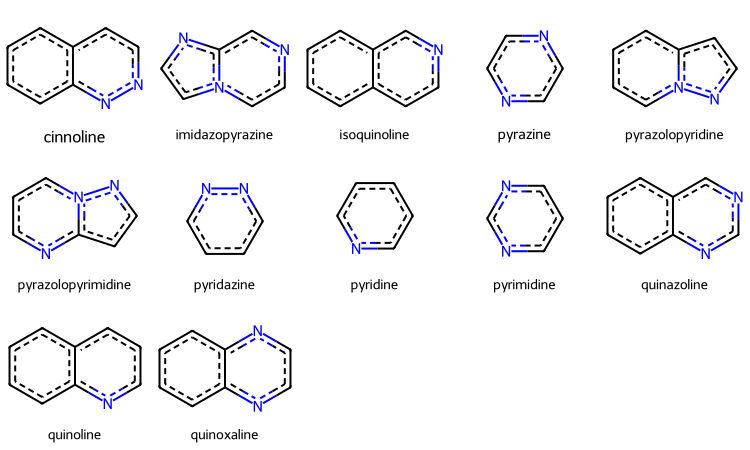

Below are all the common structures and their prefixes (reordered):


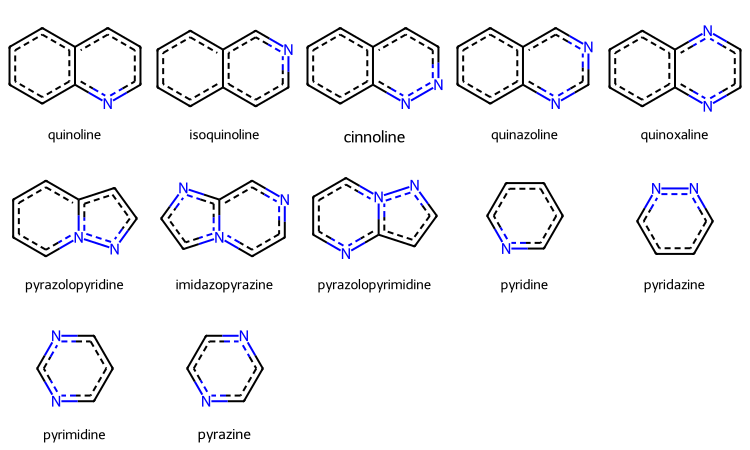

In [4]:
# we have to map to their corresponding core structures
input_common_structure_folder = "common_structure"
common_structure_list = {}
# grep all the cdxml files in the common structure folder
for file in glob.glob("*.cdxml", root_dir=input_common_structure_folder):
    # get the filename without the extension, we will use it as the prefix
    key = file.split(".")[0]
    substructure = Chem.MolsFromCDXMLFile(os.path.join(input_common_structure_folder, file))
    # output to Smarts format
    temp_smarts = Chem.MolToSmarts(substructure[0])
    # reparse the Smarts, this is in case the structure from the cdxml file is not the same as from the SMILES string
    substructure = Chem.MolFromSmarts(temp_smarts)
    # add the substructure to the dictionary
    common_structure_list[key] = substructure
common_structure_prefix = list(common_structure_list.keys())


def print_common_structure_list(common_structure_list):
    # Prepare the list of molecules and corresponding legends (for display under each molecule)
    mols = list(common_structure_list.values())
    legends = list(common_structure_list.keys())
    # Generate a grid image with a fixed number of columns (5 columns)
    img = Chem.Draw.MolsToGridImage(
        mols, molsPerRow=5, subImgSize=(150, 150), legends=legends
    )
    display(img)  # Display the grid of images

print(f"Below are all the common structures and their prefixes (unordered):")
print_common_structure_list(common_structure_list)
new_common_structure_prefix = [
    # 6 + 6 fused rings
    "quinoline",
    "isoquinoline",
    "cinnoline",
    "quinazoline",
    "quinoxaline",
    # 6 + 5 fused rings
    "pyrazolopyridine",
    "imidazopyrazine",
    "pyrazolopyrimidine",
    # single ring
    "pyridine",
    "pyridazine",
    "pyrimidine",
    "pyrazine",
]
# resort the common_structure_list
# use the reordered list to resort the dictionary
common_structure_list = {
    prefix: common_structure_list[prefix] for prefix in new_common_structure_prefix
}
print(f"Below are all the common structures and their prefixes (reordered):")
print_common_structure_list(common_structure_list)

In [5]:
# Create a dictionary mapping Compound_Name to RDKit molecule objects
compound_to_mol = {
    row["id"]: Chem.MolFromSmiles(row["SMILES"])
    for _, row in yields_df.iterrows()
}

In [6]:
# create a temp folder to store the images
os.makedirs("images", exist_ok=True)
# Function to draw and save molecule images
def draw_and_save_molecule(drawer, mol, mol_id, output_dir, with_caption: bool = True):
    matcheslist = []
    # first attempt to match the molecule to all the common structures
    for prefix in common_structure_prefix:
        if mol.HasSubstructMatch(common_structure_list[prefix]):
            mol_id = f"{mol_id} ({prefix})"
            # append the submatch atom tuples to the list
            for match in mol.GetSubstructMatches(common_structure_list[prefix]):
                matcheslist.extend(match)
            # force the molecule to have the same orientation as the common structure
            Chem.rdDepictor.Compute2DCoords(common_structure_list[prefix])
            # Chem.rdDepictor.Compute2DCoords(mol)
            Chem.rdDepictor.GenerateDepictionMatching2DStructure(mol, common_structure_list[prefix])
            break
    drawer.ClearDrawing()
    highlight_colors = {atom: ColorConverter().to_rgba("Salmon", alpha=0.8) for atom in matcheslist}
    if with_caption:
        drawer.DrawMolecule(mol, legend=mol_id, highlightAtoms=matcheslist, highlightAtomColors=highlight_colors)
        img_path = os.path.join(output_dir, f"{mol_id}_captioned.png")
    else:
        drawer.DrawMolecule(mol, highlightAtoms=matcheslist, highlightAtomColors=highlight_colors)
        img_path = os.path.join(output_dir, f"{mol_id}.png")
    drawer.FinishDrawing()
    img_data = drawer.GetDrawingText()
    with open(img_path, "wb") as f:
        f.write(img_data)
    return img_path


# Generate molecule images and save the mapping into a dictionary with keys as compound names values as image paths
common_drawer = Draw.rdMolDraw2D.MolDraw2DCairo(200, 200)  # Adjust dimensions if needed
common_drawer_drawOptions = common_drawer.drawOptions()
common_drawer_drawOptionscomicMode = True
common_drawer_drawOptionsaddAtomIndices = True
common_drawer_drawOptionscontinuousHighlight = True
# adjust the font size
common_drawer_drawOptionsbaseFontSize = 1
common_drawer_drawOptionsbondLineWidth = 5
common_drawer_drawOptionshighlightRadius = 0.35
common_drawer_drawOptionshighlightBondWidthMultiplier = 3

mol_image_paths = {name: draw_and_save_molecule(common_drawer, compound_to_mol[name], name, "images", with_caption=False) for name in select_properties_df["Compound_Name"]}
mol_image_data = {name: base64.b64encode(open(path, "rb").read()).decode() for name, path in mol_image_paths.items()}
mol_image_paths_captioned = {name: draw_and_save_molecule(common_drawer, compound_to_mol[name], name, "images", with_caption=True) for name in select_properties_df["Compound_Name"]}
mol_image_data_captioned = {name: base64.b64encode(open(path, "rb").read()).decode() for name, path in mol_image_paths_captioned.items()}

In [7]:
# plot a bar chart of the normalized "BDE (kcal/mol)" column
# sort the values based on the normalized "BDE (kcal/mol)" column in descending order
sorted_compounds = select_properties_df.sort_values("BDE (kcal/mol)")
X = sorted_compounds["Compound_Name"]
Y = select_properties_data_removed_highlycorr_normalized_df["BDE (kcal/mol)"]
fig = px.bar(
    x=X,
    y=Y.sort_values(),
    labels={"x": "Molecule", "y": "Normalized BDE (kcal/mol)"},
)
fig.update_xaxes(tickvals=select_properties_df["Compound_Name"], title_text="Molecule")
    
fig.update_layout(
    title="Normalized BDE (kcal/mol) by Compound",
    height=len(Y) * 20,
    width=len(X) * 30,
    template="plotly_white",
    xaxis=dict(tickangle=30),
)

# Show the chart
fig.show()

In [8]:
import plotly.graph_objects as go
import plotly.express as px

# Create the initial scatter plot for "Yield (Britton)"
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=yields_df["id"],
        y=yields_df["Britton"],
        mode="markers",
        name="Yield (Britton)",
        marker=dict(color="Blue", size=8),
        yaxis="y",
    )
)

# Add the second trace for "BDE (kcal/mol)" on the secondary y-axis
fig.add_trace(
    go.Scatter(
        x=yields_df["id"],
        y=select_properties_data_removed_highlycorr_normalized_df["E_spc (Hartree)"],
        mode="lines+markers",
        name="Normalized E_spc (Hartree)",
        line=dict(color="Red", width=2, dash="dash"),
        marker=dict(size=6),
        yaxis="y2",
    )
)

# Update layout to include two y-axes
fig.update_layout(
    title="Correlation Analysis: Yield (Britton) vs. Normalized E_spc (Hartree)",
    height=600,
    width=900,
    template="plotly_white",
    xaxis=dict(
        title="Molecule",
        tickangle=30,
    ),
    yaxis=dict(
        title="Yield (Britton)",
        titlefont=dict(color="Blue"),
        tickfont=dict(color="Blue"),
    ),
    yaxis2=dict(
        title="Normalized E_spc (Hartree)",
        titlefont=dict(color="Red"),
        tickfont=dict(color="Red"),
        anchor="x",
        overlaying="y",
        side="right",
    ),
    legend=dict(
        x=1,  # Position legend at the right edge
        y=1,  # Position legend at the top edge
        xanchor="right",  # Align legend to the right
        yanchor="top",  # Align legend to the top
        bgcolor="rgba(255, 255, 255, 1)",  # Transparent background
        bordercolor="Gray",  # Set border color
        borderwidth=2,  # Set border width
    ),
    font=dict(size=12, family="Arial", color="black", weight="bold"),
)

# Show the chart
fig.show()
# save to html and open in browser
fig.write_html("temp.html", auto_open=True)

In [9]:
# Calculate correlation
properties_columns = select_properties_data_removed_highlycorr_df.columns
yield_columns = yields_df.select_dtypes(include=[np.number]).columns

correlation_results = pd.DataFrame(index=properties_columns, columns=yield_columns)
for property in properties_columns:
    for method in yield_columns:
        correlation_results.loc[property, method] = select_properties_data_removed_highlycorr_normalized_df[property].corr(yield_data_df[method])
correlation_results = correlation_results.astype(float)

In [10]:
# plot the correlation matrix
fig = px.imshow(
    correlation_results.abs().values.T,
    labels=dict(x="Properties", y="Methods", color="Correlation"),
    x=correlation_results.T.columns,
    y=correlation_results.columns,
    color_continuous_scale="Reds",
    title="Correlation Matrix of Properties and Methods",
)

fig.update_layout(
    height=len(correlation_results.columns) * 50,
    width=len(correlation_results.T.columns) * 50,
    xaxis=dict(tickangle=30),
    template="plotly_white",
    font=dict(size=12, family="Arial", color="black", weight="bold"),
)

fig.update_coloraxes(
    colorbar_orientation="h",
    colorbar_y=-0.5,
    colorbar_len=0.7,
    colorbar_title="Correlation",
)

fig.show()
# save to html and open in browser
fig.write_html("temp.html", auto_open=True)

In [11]:
# Identify the top 2 important factors (positive or negative) for each method
top_factors_dict = {}

for method in correlation_results.columns:
    # Sort factors by absolute correlation values and select top 3
    top_factors = correlation_results[method].abs().sort_values(ascending=False).head(3).index.tolist()
    top_factors_dict[method] = top_factors

top_factors_dict

{'Britton': ['BDE (kcal/mol)',
  'NBO_charge_C1_Boltz',
  '%Vbur_C2_2.0amstrong_Boltz'],
 'Maity2AP Stahl': ['C1_C2_bond_order_ionic_Boltz_anion',
  'NMR_shift_C2_Boltz',
  'C1_C2_bond_order_ionic_Boltz'],
 'Maity4AP Stahl': ['Sterimol_B5_C1_C2(amstrong)_morfeus_Boltz',
  'E_spc (Hartree)',
  'Sterimol_B1_C1_C2(amstrong)_morfeus_Boltz_anion'],
 'Golden Stahl': ['C1_FormalCharge_Boltz',
  'HOMO_Boltz_openshell',
  'mu_Boltz_openshell'],
 'DeLuca': ['NBO_charge_C1_Boltz',
  'NBO_charge_C1_Boltz_anion',
  'C1_C2_bond_order_ionic_Boltz_anion'],
 'Fujisaki': ['dipole(Debye)_Boltz_openshell',
  'dipole(Debye)_Boltz',
  '%Vbur_C2_2.0amstrong_Boltz'],
 'Newkome': ['dipole(Debye)_Boltz',
  'distance_C1_C2(amstrong)_Boltz',
  'dipole(Debye)_Boltz_openshell'],
 'Xu Zhang': ['HOMO_Boltz_anion',
  'C1_Electro-Valency_Boltz_anion',
  'E_spc (Hartree)'],
 'Schreiner': ['NMR_shift_C2_Boltz',
  'pyramidalization_Gavrish_C1(degree)_Boltz',
  'Sterimol_B1_C1_C2(amstrong)_morfeus_Boltz'],
 'Chen': ['mu_Bo

In [12]:
import plotly.express as px

# Create bar charts for each method
for method, factors in top_factors_dict.items():
    # Prepare data for the chart
    data = correlation_results.loc[factors, method].reset_index()
    data.columns = ["Factor", "Correlation"]
    data["Absolute Correlation"] = data["Correlation"].abs()

    # Create the bar chart
    fig = px.bar(
        data,
        x="Factor",
        y="Absolute Correlation",
        text="Correlation",  # Add original correlation values as text
        title=f"Top 3 Factors for {method}",
        labels={"Absolute Correlation": "Correlation Value (|r|)", "Factor": "Property"},
    )

    # Customize layout
    fig.update_traces(texttemplate="%{text:.2f}", textposition="inside")  # Format text
    fig.update_layout(
        height=500,
        width=800,
        template="plotly_white",
        xaxis_title="Factors",
        yaxis_title="Abs Correlation",
    )

    # Show the chart
    fig.show()

In [13]:
import plotly.express as px

# Prepare a matrix with only top 5 factors for each method
filtered_matrix = correlation_results.copy()
filtered_matrix[:] = 0  # Initialize with zeros

for method, factors in top_factors_dict.items():
    # Retain only the top 5 factors
    filtered_matrix.loc[factors, method] = correlation_results.loc[factors, method]

# Plot the 2D matrix
fig = px.imshow(
    filtered_matrix.T,
    labels={"x": "Property", "y": "Method", "color": "Correlation"},
    color_continuous_scale="RdBu",  # Diverging color scale
    title="Top 3 Factors for Each Method",
)

# Customize layout
fig.update_layout(
    height=len(filtered_matrix.columns) * 60,
    width=len(filtered_matrix) * 50,
    xaxis_title="Property",
    xaxis=dict(tickangle=30),
    yaxis_title="Method Yields",
    template="plotly_white",
    font=dict(size=16, family="Arial", color="black", weight="bold"),
)

fig.update_coloraxes(colorbar_len=1)

# Show the plot
fig.show()

In [14]:
# count how many times each factor is in the top 3
top_factors = pd.Series([factor for factors in top_factors_dict.values() for factor in factors])
top_factors_count = top_factors.value_counts()
top_factors_count

NBO_charge_C1_Boltz                                3
C1_C2_bond_order_ionic_Boltz_anion                 3
NMR_shift_C2_Boltz                                 3
dipole(Debye)_Boltz                                3
distance_C1_C2(amstrong)_Boltz                     3
C1_C2_bond_order_ionic_Boltz                       2
%Vbur_C2_2.0amstrong_Boltz                         2
BDE (kcal/mol)                                     2
dipole(Debye)_Boltz_openshell                      2
E_spc (Hartree)                                    2
mu_Boltz_openshell                                 2
HOMO_Boltz_openshell                               2
C1_Electro-Valency_Boltz_anion                     2
Sterimol_B5_C1_C2(amstrong)_morfeus_Boltz          1
Sterimol_B1_C1_C2(amstrong)_morfeus_Boltz_anion    1
C1_FormalCharge_Boltz                              1
NBO_charge_C1_Boltz_anion                          1
HOMO_Boltz_anion                                   1
pyramidalization_Gavrish_C1(degree)_Boltz     

In [15]:
# plot this as a bar chart
fig = px.bar(
    x=top_factors_count.index,
    y=top_factors_count,
    labels={"x": "Property", "y": "Count"},
    title="Top 3 Factors Count",
)

fig.update_traces(marker_color="Maroon")

fig.update_layout(
    height=600,
    width=1000,
    xaxis=dict(tickangle=30),
    template="plotly_white",
    xaxis_title="Property",
    yaxis_title="Count",
    font=dict(size=16, family="Arial", color="black", weight="bold"),
)

In [16]:
len(top_factors_count)

24

In [17]:
display(select_properties_data_df.head(1))
display(select_properties_data_removed_highlycorr_df.head(1))
display(select_properties_data_removed_highlycorr_normalized_df.head(1))

,BDE (kcal/mol),BDFE (kcal/mol),E_spc (Hartree),E_spc (Hartree)_anion,E_spc (Hartree)_openshell,H_spc(Hartree),H_spc(Hartree)_anion,H_spc(Hartree)_openshell,qh_G(T)_spc(Hartree),qh_G(T)_spc(Hartree)_anion,...,C1_Electro-Valency_Boltz,C1_Electro-Valency_Boltz_anion,C1_FormalCharge_Boltz,C1_FormalCharge_Boltz_anion,C2_Co-Valency_Boltz,C2_Co-Valency_Boltz_anion,C2_Electro-Valency_Boltz,C2_Electro-Valency_Boltz_anion,C2_FormalCharge_Boltz,C2_FormalCharge_Boltz_anion
0,90.96998,83.154355,-441.215801,-440.620459,-440.561375,-441.043098,-440.463017,-440.40235,-441.085759,-440.504702,...,0.6784,0.5491,0.0006,-0.2896,3.5377,3.4047,0.4177,0.5367,-0.0308,-0.0333


,BDE (kcal/mol),E_spc (Hartree),HOMO_Boltz,HOMO_Boltz_anion,HOMO_Boltz_openshell,LUMO_Boltz,LUMO_Boltz_anion,LUMO_Boltz_openshell,mu_Boltz,mu_Boltz_openshell,...,C1_C2_bond_order_total_Boltz,C1_C2_bond_order_covalent_Boltz,C1_C2_bond_order_ionic_Boltz,C1_C2_bond_order_ionic_Boltz_anion,C1_Electro-Valency_Boltz_anion,C1_FormalCharge_Boltz,C1_FormalCharge_Boltz_anion,C2_Co-Valency_Boltz_anion,C2_FormalCharge_Boltz,C2_FormalCharge_Boltz_anion
0,90.96998,-441.215801,-0.28447,-0.03713,-0.2444,-0.02605,0.14427,-0.02204,-0.15526,-0.13322,...,0.9552,0.9433,0.012,0.2036,0.5491,0.0006,-0.2896,3.4047,-0.0308,-0.0333


,BDE (kcal/mol),E_spc (Hartree),HOMO_Boltz,HOMO_Boltz_anion,HOMO_Boltz_openshell,LUMO_Boltz,LUMO_Boltz_anion,LUMO_Boltz_openshell,mu_Boltz,mu_Boltz_openshell,...,C1_C2_bond_order_total_Boltz,C1_C2_bond_order_covalent_Boltz,C1_C2_bond_order_ionic_Boltz,C1_C2_bond_order_ionic_Boltz_anion,C1_Electro-Valency_Boltz_anion,C1_FormalCharge_Boltz,C1_FormalCharge_Boltz_anion,C2_Co-Valency_Boltz_anion,C2_FormalCharge_Boltz,C2_FormalCharge_Boltz_anion
0,0.954868,-0.614314,0.968695,-0.849995,0.109182,-0.367607,-0.614495,-0.560989,0.757287,-0.320011,...,-0.564858,-0.57631,-0.451833,0.533754,0.594303,-0.155124,0.083136,-0.089852,0.58772,1.086271


In [18]:
# remove column that end with either "_anion" or "_cation"
select_properties_data_df_filtered = select_properties_data_removed_highlycorr_normalized_df.loc[:, ~select_properties_data_removed_highlycorr_normalized_df.columns.str.endswith('_openshell')]
# select_properties_data_df_filtered = select_properties_data_df.loc[:, ~select_properties_data_df.columns.str.endswith('_anion') & ~select_properties_data_df.columns.str.endswith('_openshell')]
select_properties_data_df_filtered.head(1)

,BDE (kcal/mol),E_spc (Hartree),HOMO_Boltz,HOMO_Boltz_anion,LUMO_Boltz,LUMO_Boltz_anion,mu_Boltz,eta_Boltz,eta_Boltz_anion,omega_Boltz,...,C1_C2_bond_order_total_Boltz,C1_C2_bond_order_covalent_Boltz,C1_C2_bond_order_ionic_Boltz,C1_C2_bond_order_ionic_Boltz_anion,C1_Electro-Valency_Boltz_anion,C1_FormalCharge_Boltz,C1_FormalCharge_Boltz_anion,C2_Co-Valency_Boltz_anion,C2_FormalCharge_Boltz,C2_FormalCharge_Boltz_anion
0,0.954868,-0.614314,0.968695,-0.849995,-0.367607,-0.614495,0.757287,-0.769923,-0.320531,0.016365,...,-0.564858,-0.57631,-0.451833,0.533754,0.594303,-0.155124,0.083136,-0.089852,0.58772,1.086271


In [19]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

decision_tree_X = select_properties_data_removed_highlycorr_normalized_df

# build a decision tree model for each method
models = {}

for method in yield_columns:
    # Prepare the training data
    X = decision_tree_X
    y = yield_data_df[method]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed
    )
    # display(X_train.head(2))
    # display(y_train.head(2))
    # print(f"Method: {method}, Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

    # Create and train the model
    model = DecisionTreeRegressor(criterion="squared_error", random_state=random_seed)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    # display(pd.DataFrame({"Actual": y_test, "Predicted": y_pred}))
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Store the model and metrics
    models[method] = {"model": model, "mse": mse, "r2_score": r2}

    print(f"Method: {method}, MSE: {mse:.2f}, R^2: {r2:.2f}")
    
# average the MSE across all methods
average_mse = np.mean([metrics["mse"] for metrics in models.values()])
print(f"Average MSE: {average_mse:.2f}")
average_r2 = np.mean([metrics["r2_score"] for metrics in models.values()])
print(f"Average R^2: {average_r2:.2f}")

Method: Britton, MSE: 744.71, R^2: -0.21
Method: Maity2AP Stahl, MSE: 1724.67, R^2: -0.01
Method: Maity4AP Stahl, MSE: 2127.74, R^2: -0.24
Method: Golden Stahl, MSE: 1133.15, R^2: -0.87
Method: DeLuca, MSE: 1715.58, R^2: -45.73
Method: Fujisaki, MSE: 105.15, R^2: -4.21
Method: Newkome, MSE: 3492.35, R^2: -4.22
Method: Xu Zhang, MSE: 166.73, R^2: 0.84
Method: Schreiner, MSE: 859.44, R^2: -1.59
Method: Chen, MSE: 1516.29, R^2: -1.07
Method: Wu, MSE: 367.99, R^2: -0.92
Method: Lopez Stahl, MSE: 3.29, R^2: -0.75
Method: Ariarfard, MSE: 902.30, R^2: -0.20
Method: Kanai, MSE: 781.13, R^2: -1.13
Average MSE: 1117.18
Average R^2: -4.31


In [20]:
# found the top 3 important factors for each method
decision_tree_top_factors_dict = {}

for method in models.keys():
    # Extract feature importances
    feature_importances = models[method]["model"].feature_importances_
    # Sort factors by importance and select top 3
    top_factors = decision_tree_X.columns[np.argsort(feature_importances)[::-1][:3]]
    print(f"Method: {method}, Top Factors: [{', '.join(top_factors)}]")
    decision_tree_top_factors_dict[method] = top_factors

Method: Britton, Top Factors: [NBO_charge_C1_Boltz, Sterimol_B5_C1_C2(amstrong)_morfeus_Boltz, Sterimol_B1_C1_C2(amstrong)_morfeus_Boltz_anion]
Method: Maity2AP Stahl, Top Factors: [dipole(Debye)_Boltz, C1_Electro-Valency_Boltz_anion, HOMO_Boltz]
Method: Maity4AP Stahl, Top Factors: [volume(Bohr_radius^3/mol)_Boltz_anion, eta_Boltz, Sterimol_B1_C1_C2(amstrong)_morfeus_Boltz]
Method: Golden Stahl, Top Factors: [BDE (kcal/mol), NMR_shift_C2_Boltz, distance_C1_C2(amstrong)_Boltz_anion]
Method: DeLuca, Top Factors: [C1_FormalCharge_Boltz, dipole(Debye)_Boltz, dipole(Debye)_Boltz_openshell]
Method: Fujisaki, Top Factors: [volume(Bohr_radius^3/mol)_Boltz, Sterimol_B1_C1_C2(amstrong)_morfeus_Boltz_anion, %Vbur_C2_2.0amstrong_Boltz]
Method: Newkome, Top Factors: [volume(Bohr_radius^3/mol)_Boltz_anion, C1_Electro-Valency_Boltz_anion, NBO_charge_C2_Boltz_anion]
Method: Xu Zhang, Top Factors: [HOMO_Boltz_anion, BDE (kcal/mol), NBO_charge_C1_Boltz_anion]
Method: Schreiner, Top Factors: [pyramidali

In [21]:
import plotly.graph_objects as go

# Prepare data for the chart
methods = list(models.keys())
mse_values = [metrics["mse"] for metrics in models.values()]
r2_values = [metrics["r2_score"] for metrics in models.values()]

# Create the figure
fig = go.Figure()

# Add MSE as bars
fig.add_trace(
    go.Bar(
        x=methods,
        y=mse_values,
        name="MSE",
        marker=dict(color="LightSalmon"),
        text=[f"{val:.2f}" for val in mse_values],  # Add text labels for MSE
        textposition="outside",
        yaxis="y1",  # Corresponds to primary y-axis
    )
)

# Add R² as a dashed line with scatter points and text
fig.add_trace(
    go.Scatter(
        x=methods,
        y=r2_values,
        mode="lines+markers+text",  # Add text to scatter points
        name="R²",
        line=dict(color="DeepSkyBlue", dash="dash"),
        marker=dict(size=8, color="DeepSkyBlue"),
        text=[f"{val:.2f}" for val in r2_values],  # Text for R² values
        textposition="top center",  # Position text above the points
        textfont=dict(color="Grey", size=16),  # Match text color to the line color
        yaxis="y2",  # Corresponds to secondary y-axis
    )
)

# Update layout for dual y-axes
fig.update_layout(
    title="MSE and R² Scores for Decision Tree Models",
    xaxis=dict(title="Method"),
    yaxis=dict(
        title="MSE",
        titlefont=dict(color="LightSalmon"),
        tickfont=dict(color="LightSalmon"),
    ),
    yaxis2=dict(
        title="R²",
        titlefont=dict(color="DeepSkyBlue"),
        tickfont=dict(color="DeepSkyBlue"),
        overlaying="y",
        side="right",
    ),
    width=1500,
    height=800,
    template="plotly_white",
    legend=dict(
        x=1,  # Legend position at the right edge
        y=0.8,  # Top position
        xanchor="right",
        yanchor="top",
        bgcolor="rgba(255, 255, 255, 1)",  # Transparent background
        bordercolor="Gray",
        borderwidth=2,
    ),
    font=dict(size=16, family="Arial", color="black", weight="bold"),
)

# Show the chart
fig.show()

In [22]:
# count the number of times each factor is in the top 3
decision_tree_top_factors = pd.Series([factor for factors in decision_tree_top_factors_dict.values() for factor in factors])
decision_tree_top_factors_count = decision_tree_top_factors.value_counts()
decision_tree_top_factors_count

NMR_shift_C2_Boltz                                 3
BDE (kcal/mol)                                     3
C2_FormalCharge_Boltz_anion                        3
C1_Electro-Valency_Boltz_anion                     2
dipole(Debye)_Boltz                                2
volume(Bohr_radius^3/mol)_Boltz_anion              2
C1_FormalCharge_Boltz                              2
C1_C2_bond_order_ionic_Boltz                       2
Sterimol_B1_C1_C2(amstrong)_morfeus_Boltz_anion    2
NBO_charge_C1_Boltz_anion                          2
Sterimol_B1_C1_C2(amstrong)_morfeus_Boltz          1
Sterimol_B5_C1_C2(amstrong)_morfeus_Boltz          1
NBO_charge_C1_Boltz                                1
distance_C1_C2(amstrong)_Boltz_anion               1
HOMO_Boltz                                         1
eta_Boltz                                          1
dipole(Debye)_Boltz_openshell                      1
NBO_charge_C2_Boltz_anion                          1
%Vbur_C2_2.0amstrong_Boltz                    

In [23]:
len(decision_tree_top_factors_count)

29

In [24]:
# plot the frequency of the top 3 factors
fig = px.bar(
    x=decision_tree_top_factors_count.index,
    y=decision_tree_top_factors_count,
    labels={"x": "Property", "y": "Count"},
    title="Top 3 Factors Count",
)

fig.update_traces(marker_color="Maroon")

fig.update_layout(
    height=600,
    width=1000,
    xaxis=dict(tickangle=30),
    template="plotly_white",
    xaxis_title="Property",
    yaxis_title="Count",
    font=dict(size=16, family="Arial", color="black", weight="bold"),
)

# Show the chart
fig.show()

In [25]:
# ok now do that for every method
os.makedirs("decision_trees", exist_ok=True)
# delete all files in the directory
for file in os.listdir("decision_trees"):
    os.remove(os.path.join("decision_trees", file))

for method, metrics in models.items():
    dot_data = export_graphviz(
        metrics["model"],
        out_file=None,
        feature_names=decision_tree_X.columns,
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    graph.render(
        f"decision_trees/{method}",
        format="png",
        cleanup=True,
    )

### PCA

In [26]:
from sklearn.decomposition import PCA

df = select_properties_data_removed_highlycorr_normalized_df

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df)

# Get the most contributing factors for the first two principal components
pc1_contributions = abs(pca.components_[0])
pc2_contributions = abs(pca.components_[1])
pc1_top_factors = df.columns[pc1_contributions.argsort()[::-1][:5]]
pc2_top_factors = df.columns[pc2_contributions.argsort()[::-1][:5]]
print(f"Top factors for PC1: {[factor for factor in pc1_top_factors]}")
print(f"Top factors for PC2: {[factor for factor in pc2_top_factors]}")

Top factors for PC1: ['E_spc (Hartree)', 'eta_Boltz', 'volume(Bohr_radius^3/mol)_Boltz', 'LUMO_Boltz_anion', 'eta_Boltz_openshell']
Top factors for PC2: ['distance_C1_C2(amstrong)_Boltz_openshell', 'NMR_shift_C1_Boltz', 'NBO_charge_C1_Boltz_anion', 'C1_C2_bond_order_ionic_Boltz_anion', 'NBO_charge_C1_Boltz']


In [27]:
pca_result.shape

(35, 2)

In [28]:
# Prepare PCA DataFrame
pca_df = select_properties_data_removed_highlycorr_normalized_df.copy()
pca_df["PC1"] = pca_result[:, 0]
pca_df["PC2"] = pca_result[:, 1]

# Get all yield methods
yield_columns = yields_df.select_dtypes(include=[np.number]).columns

# add 5 to all yield values to make them positive
yields_df[yield_columns] = yields_df[yield_columns] + 5

# Create a subplot structure
fig = make_subplots(
    rows=len(yield_columns),
    cols=1,
    subplot_titles=[f"PCA Scatter Plot for {method}" for method in yield_columns],
    vertical_spacing = 0.01,
)

# Loop over each yield method
for i, yield_column in enumerate(yield_columns, start=1):
    pca_df["Yield"] = yields_df[yield_column]

    # Create scatter plot for the method
    scatter = px.scatter(
        pca_df,
        x="PC1",
        y="PC2",
        size="Yield",
        color="Yield",
        title=f"PCA Scatter Plot for {yield_column}",
        labels={
            "PC1": "Principal Component 1",
            "PC2": "Principal Component 2",
            "Yield": "Yield",
        },
        # marginal_x = "histogram",
        # marginal_y = "histogram",
        template="simple_white",
    )

    # Add trace to the subplot
    for trace in scatter.data:
        fig.add_trace(trace, row=i, col=1)

# Update layout for all plots
fig.update_layout(
    height=600 * len(yield_columns),
    width=1200,
    title="PCA Scatter Plots with Yield Sizes for All Methods",
    showlegend=False,
)

# Customize x and y axes for each subplot
for i in range(len(yield_columns)):
    fig.update_xaxes(
        title_text="Principal Component 1",
        showgrid=True,
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor="black",
        gridcolor="lightgrey",
        row=i + 1,
        col=1,
    )
    fig.update_yaxes(
        title_text="Principal Component 2",
        showgrid=True,
        zeroline=True,
        zerolinewidth=2,
        zerolinecolor="black",
        gridcolor="lightgrey",
        row=i + 1,
        col=1,
    )

# Save the plots as an HTML file and open in the browser
output_file = "temp.html"
pio.write_html(fig, file=output_file, auto_open=True)

### Classification

In [29]:
# Binarize the yield data: 0 if yield < 2, 1 if yield is between 2 to 40, 2 if yield > 40
# starting with a full 0 dataframe
classification_yields_df = pd.DataFrame(0, index=yield_data_df.index, columns=yield_data_df.columns)
# add one to all values that are between 2 and 40
classification_yields_df[(yield_data_df >= 2) & (yield_data_df <= 40)] = 1
# add two to all values that are greater than 40
classification_yields_df[yield_data_df > 40] = 2

# drop row "Lopez Stahl" and "Fujisaki" from the classification_yields_df dataframe
classification_yields_df = classification_yields_df.drop(["Lopez Stahl", "Fujisaki"], axis=1)

In [30]:
# Build the heatmap
fig = go.Figure(
    data=go.Heatmap(
        z=classification_yields_df.T.to_numpy(),
        x=yields_df["id"],
        y=classification_yields_df.columns,
        colorscale="Reds",
        text=classification_yields_df.T.to_numpy(),
        texttemplate="%{text:.d}",
        showscale=True,
    )
)

# Update layout
fig.update_layout(
    xaxis_title="Compound ID",
    yaxis_title="Method",
    height=len(classification_yields_df.columns) * 50,
    width=len(yields_df["id"]) * 50,
    xaxis=dict(tickangle=30),
    template="plotly",
    font=dict(size=16, family="Arial", color="black", weight="bold"),
)

fig.show()

In [31]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Prepare the feature dataset
X = select_properties_data_removed_highlycorr_normalized_df

# Store models and metrics
classification_models = {}

for method in classification_yields_df.columns:
    # Target variable
    y = classification_yields_df[method]
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
    
    # Create and train the decision tree classifier
    clf = DecisionTreeClassifier(criterion="gini", random_state=random_seed)
    clf.fit(X_train, y_train)
    
    # Evaluate the classifier
    y_pred = clf.predict(X_test)
    display(pd.DataFrame({"Actual": y_test, "Predicted": y_pred}))
    # train_pred = clf.predict(X_train)
    # display(pd.DataFrame({"Actual": y_train, "Predicted": train_pred}))
    total_pred = clf.predict(X)
    report = classification_report(y_test, y_pred, output_dict=True)
    matrix = confusion_matrix(y_test, y_pred)
    matrix_total = confusion_matrix(y, total_pred)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)
    
    # Store the model and metrics
    classification_models[method] = {
        "model": clf,
        "classification_report": report,
        "confusion_matrix": matrix,
        "f1_score": f1,
        'total_confusion_matrix': matrix_total
    }
    
    print(f"Method: {method}")
    print("Confusion Matrix on testing set:")
    print(matrix)
    print("Confusion Matrix on entire dataset:")
    print(matrix_total)
    print(f"F1 Score: {f1:.2f}")
    
# print the average F1 score
average_f1 = np.mean([metrics["f1_score"] for metrics in classification_models.values()])
print(f"Average F1 Score: {average_f1:.2f}")

,Actual,Predicted
26,1,1
13,2,0
24,2,2
21,1,1
15,0,0
29,1,0
19,0,0


Method: Britton
Confusion Matrix on testing set:
[[2 0 0]
 [1 2 0]
 [1 0 1]]
Confusion Matrix on entire dataset:
[[17  0  0]
 [ 1 11  0]
 [ 1  0  5]]
F1 Score: 0.72


,Actual,Predicted
26,0,0
13,2,0
24,1,2
21,1,0
15,2,1
29,1,1
19,0,0


Method: Maity2AP Stahl
Confusion Matrix on testing set:
[[2 0 0]
 [1 1 1]
 [1 1 0]]
Confusion Matrix on entire dataset:
[[17  0  0]
 [ 1  6  1]
 [ 1  1  8]]
F1 Score: 0.36


,Actual,Predicted
26,0,0
13,2,1
24,0,1
21,0,0
15,2,1
29,1,0
19,0,0


Method: Maity4AP Stahl
Confusion Matrix on testing set:
[[3 1 0]
 [1 0 0]
 [0 2 0]]
Confusion Matrix on entire dataset:
[[15  1  0]
 [ 1 13  0]
 [ 0  2  3]]
F1 Score: 0.43


c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Actual,Predicted
26,0,1
13,1,1
24,2,1
21,1,1
15,2,2
29,1,2
19,2,2


Method: Golden Stahl
Confusion Matrix on testing set:
[[0 1 0]
 [0 2 1]
 [0 1 2]]
Confusion Matrix on entire dataset:
[[ 3  1  0]
 [ 0  9  1]
 [ 0  1 20]]
F1 Score: 0.53


c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,Actual,Predicted
26,1,1
13,1,0
24,1,1
21,1,2
15,1,0
29,1,1
19,1,1


Method: DeLuca
Confusion Matrix on testing set:
[[0 0 0]
 [2 4 1]
 [0 0 0]]
Confusion Matrix on entire dataset:
[[ 5  0  0]
 [ 2 17  1]
 [ 0  0 10]]
F1 Score: 0.73


c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



,Actual,Predicted
26,0,0
13,2,0
24,2,1
21,2,1
15,2,2
29,2,0
19,2,0


Method: Newkome
Confusion Matrix on testing set:
[[1 0 0]
 [0 0 0]
 [3 2 1]]
Confusion Matrix on entire dataset:
[[ 9  0  0]
 [ 0 16  0]
 [ 3  2  5]]
F1 Score: 0.30


c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



,Actual,Predicted
26,1,0
13,2,2
24,0,1
21,1,1
15,2,2
29,1,0
19,0,0


Method: Xu Zhang
Confusion Matrix on testing set:
[[1 1 0]
 [2 1 0]
 [0 0 2]]
Confusion Matrix on entire dataset:
[[ 9  1  0]
 [ 2 16  0]
 [ 0  0  7]]
F1 Score: 0.57


,Actual,Predicted
26,1,1
13,2,0
24,1,2
21,1,0
15,1,0
29,1,1
19,1,1


Method: Schreiner
Confusion Matrix on testing set:
[[0 0 0]
 [2 3 1]
 [1 0 0]]
Confusion Matrix on entire dataset:
[[ 5  0  0]
 [ 2 20  1]
 [ 1  0  6]]
F1 Score: 0.57


c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



,Actual,Predicted
26,1,0
13,2,1
24,2,0
21,1,1
15,1,1
29,1,0
19,0,2


Method: Chen
Confusion Matrix on testing set:
[[0 0 1]
 [2 2 0]
 [1 1 0]]
Confusion Matrix on entire dataset:
[[10  0  1]
 [ 2 19  0]
 [ 1  1  1]]
F1 Score: 0.33


,Actual,Predicted
26,1,1
13,1,0
24,1,1
21,1,1
15,1,0
29,2,1
19,0,1


c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Method: Wu
Confusion Matrix on testing set:
[[0 1 0]
 [2 3 0]
 [0 1 0]]
Confusion Matrix on entire dataset:
[[10  1  0]
 [ 2 21  0]
 [ 0  1  0]]
F1 Score: 0.43


,Actual,Predicted
26,0,0
13,2,0
24,0,0
21,0,0
15,2,2
29,1,1
19,1,1


Method: Ariarfard
Confusion Matrix on testing set:
[[3 0 0]
 [0 2 0]
 [1 0 1]]
Confusion Matrix on entire dataset:
[[16  0  0]
 [ 0 16  0]
 [ 1  0  2]]
F1 Score: 0.84


,Actual,Predicted
26,1,1
13,1,1
24,2,0
21,1,0
15,1,1
29,2,1
19,1,1


Method: Kanai
Confusion Matrix on testing set:
[[0 0 0]
 [1 4 0]
 [1 1 0]]
Confusion Matrix on entire dataset:
[[ 6  0  0]
 [ 1 18  0]
 [ 1  1  8]]
F1 Score: 0.57
Average F1 Score: 0.53


c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\R9000P\stahl_data_science\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_div

In [32]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Define the number of rows and columns for the subplots
cols = 4
rows = len(classification_models) // cols + len(classification_models) % cols


# Create a subplot figure for all confusion matrices
fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=list(classification_models.keys()),  # Titles for each subplot
    vertical_spacing=0.03,
    horizontal_spacing=0.01,
)

# Iterate through all methods and add their confusion matrix as a heatmap
for i, (method, metrics) in enumerate(classification_models.items()):
    row = i // cols + 1
    col = i % cols + 1
    cm = metrics["confusion_matrix"]

    # Add heatmap to the subplot
    fig.add_trace(
        go.Heatmap(
            z=cm,
            x=(
                ["Class 0", "Class 1", "Class 2"] if row == rows else []
            ),  # Show x-axis labels only for the first column
            y=(
                ["Class 0", "Class 1", "Class 2"] if col == 1 else []
            ),  # Show y-axis labels only for the last row
            colorscale="Reds",
            showscale=False,
            colorbar=dict(title="Count"),
        ),
        row=row,
        col=col,
    )

    # Add text annotations for confusion matrix values
    for j in range(cm.shape[0]):
        for k in range(cm.shape[1]):
            fig.add_annotation(
                x=k,
                y=j,
                text=str(cm[j, k]),
                showarrow=False,
                font=dict(color="black", size=20),
                xref=f"x{i + 1}",
                yref=f"y{i + 1}",
                xanchor="center",
                yanchor="middle",
            )

# Disable axes for internal matrices
for i in range(rows):
    for j in range(cols):
        fig.update_xaxes(
            visible=(i == rows - 1), row=i + 1, col=j + 1
        )  # X-axis visible only for the last row
        fig.update_yaxes(
            visible=(j == 0), row=i + 1, col=j + 1
        )  # Y-axis visible only for the first column

# Update layout
fig.update_layout(
    title="Confusion Matrices for All Methods on ONLY the testing set",
    height=rows * 300,
    width=cols * 300,
    template="plotly_white",
    font=dict(size=16, family="Arial", color="black", weight="bold"),
)

# Show the figure
fig.show()
# save to html and open in browser
fig.write_html("temp.html", auto_open=True)

In [33]:
# found the top 3 important factors for each method
decision_tree_top_factors_dict = {}

for method in classification_models.keys():
    # Extract feature importances
    feature_importances = classification_models[method]["model"].feature_importances_
    # Sort factors by importance and select top 3
    top_factors = decision_tree_X.columns[np.argsort(feature_importances)[::-1][:3]]
    print(f"Method: {method}, Top Factors: [{', '.join(top_factors)}]")
    decision_tree_top_factors_dict[method] = top_factors
    # if 'distance_C1_C2(amstrong)_Boltz' in top_factors:
        # print(f"found distance_C1_C2(amstrong)_Boltz in {method}")

Method: Britton, Top Factors: [NBO_charge_C1_Boltz, C1_FormalCharge_Boltz_anion, C2_FormalCharge_Boltz_anion]
Method: Maity2AP Stahl, Top Factors: [dipole(Debye)_Boltz_anion, NBO_charge_C2_Boltz_anion, C1_FormalCharge_Boltz]
Method: Maity4AP Stahl, Top Factors: [volume(Bohr_radius^3/mol)_Boltz_anion, C1_C2_bond_order_ionic_Boltz, NMR_shift_C2_Boltz]
Method: Golden Stahl, Top Factors: [HOMO_Boltz_openshell, distance_C1_C2(amstrong)_Boltz_anion, pyramidalization_Gavrish_C1(degree)_Boltz]
Method: DeLuca, Top Factors: [dipole(Debye)_Boltz_anion, NBO_charge_C1_Boltz_anion, distance_C1_C2(amstrong)_Boltz]
Method: Newkome, Top Factors: [dipole(Debye)_Boltz, C1_C2_bond_order_ionic_Boltz_anion, BDE (kcal/mol)]
Method: Xu Zhang, Top Factors: [NBO_charge_C2_Boltz, distance_C1_C2(amstrong)_Boltz, NBO_charge_C1_Boltz]
Method: Schreiner, Top Factors: [NBO_charge_C2_Boltz_anion, %Vbur_C2_2.0amstrong_Boltz, C1_C2_bond_order_covalent_Boltz]
Method: Chen, Top Factors: [dipole(Debye)_Boltz_openshell, C2_

In [34]:
# count the number of times each factor is in the top 3
decision_tree_top_factors = pd.Series([factor for factors in decision_tree_top_factors_dict.values() for factor in factors])
decision_tree_top_factors_count = decision_tree_top_factors.value_counts()
decision_tree_top_factors_count

dipole(Debye)_Boltz_anion                    4
distance_C1_C2(amstrong)_Boltz               4
NBO_charge_C1_Boltz                          2
NBO_charge_C2_Boltz_anion                    2
C2_FormalCharge_Boltz_anion                  2
dipole(Debye)_Boltz                          2
C1_C2_bond_order_covalent_Boltz              2
C1_FormalCharge_Boltz                        1
C1_FormalCharge_Boltz_anion                  1
NMR_shift_C2_Boltz                           1
C1_C2_bond_order_ionic_Boltz                 1
volume(Bohr_radius^3/mol)_Boltz_anion        1
HOMO_Boltz_openshell                         1
NBO_charge_C1_Boltz_anion                    1
pyramidalization_Gavrish_C1(degree)_Boltz    1
C1_C2_bond_order_ionic_Boltz_anion           1
distance_C1_C2(amstrong)_Boltz_anion         1
BDE (kcal/mol)                               1
NBO_charge_C2_Boltz                          1
%Vbur_C2_2.0amstrong_Boltz                   1
dipole(Debye)_Boltz_openshell                1
C2_Co-Valency

In [35]:
len(decision_tree_top_factors_count)

25

In [36]:
# ok now do that for every method
os.makedirs("decision_trees_clf", exist_ok=True)
# delete all files in the directory
for file in os.listdir("decision_trees_clf"):
    os.remove(os.path.join("decision_trees_clf", file))

for method, metrics in classification_models.items():
    dot_data = export_graphviz(
        metrics["model"],
        out_file=None,
        feature_names=decision_tree_X.columns,
        filled=True,
        rounded=True,
        special_characters=True,
    )
    graph = graphviz.Source(dot_data)
    graph.render(
        f"decision_trees_clf/{method}",
        format="png",
        cleanup=True,
    )